In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [4]:
metadata = pd.read_csv('/content/drive/MyDrive/archive (17)/bird_songs_metadata.csv')
metadata.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [5]:
# Lists for storing the filepaths and labels
file_paths = []
labels = []

audio_dir = '/content/drive/MyDrive/archive (17)/wavfiles/'

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    if os.path.exists(file_path):
        file_paths.append(file_path)
        labels.append(row['species'])

file_paths[:5], labels[:5]

(['/content/drive/MyDrive/archive (17)/wavfiles/557838-0.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-1.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-4.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-5.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-6.wav'],
 ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii'])

In [6]:
# Converting labels to numeric
label_dict = {label: index for index, label in enumerate(set(labels))}
y = np.array([label_dict[label] for label in labels])
y[:5]

array([3, 3, 3, 3, 3])

In [7]:
# Function to read audio file
def read_file(path):
    y, _ = librosa.load(path, sr=22050)  # Set the sample rate to ensure consistency
    return y

# Function to convert to dB scale
def spec_to_db(y):
    y_db = librosa.power_to_db(y, ref=np.max)
    #y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    # Load audio file
    y = tf.numpy_function(read_file, inp=[path_tensor], Tout=tf.float32)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))

    mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=tf.shape(spectrogram)[-1],
        sample_rate=22050,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0)
    mel_spectrogram = tf.matmul(spectrogram, mel_weights)

    # Convert to dB scale
    #log_mel_spectrogram = tf.numpy_function(spec_to_db, inp=[mel_spectrogram], Tout=tf.float32)

    #spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    #spectrogram_db = spectrogram_db/80+1

    return mel_spectrogram, label


def make_dataset(labels, file_paths, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=64, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
file_paths_train, file_paths_test, y_train, y_test = train_test_split(
    file_paths, y, test_size=0.20, random_state=42)

dataset_train = make_dataset(y_train, file_paths_train, shuffle=True)
dataset_test = make_dataset(y_test, file_paths_test, shuffle=False)

for batch in dataset_train.take(1):
    input_data_shape = batch[0].shape
print("Shape of input data in training dataset:", input_data_shape)

Shape of input data in training dataset: (64, 1026, 128)


In [9]:
def create_model():
    inputs = Input((1026, 128), name = '0_Input_shape')

    x = Conv1D(64,8,2, activation='relu', padding='same', name = '1_Conv1D')(inputs)
    x = SpatialDropout1D(0.17, name = '2_SpatialDropout1D')(x)

    x = Conv1D(64,8,2, activation='relu', padding='same', name = '3_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '4_SpatialDropout1D')(x)

    x = Conv1D(64,8,2, activation='relu', padding='same', name = '5_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '6_SpatialDropout1D')(x)

    x = Conv1D(64,8,2, activation='relu', padding='same', name = '7_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '8_SpatialDropout1D')(x)

    x = GlobalAveragePooling1D(name = '9_Global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='10_Dense')(x)
    x = Dropout(0.5, name='11_Dropout')(x)
    outputs = Dense(5, name='12_Dense')(x)
    model = Model(inputs=inputs, outputs=outputs, name = 'Bird_audio_classification_model')

    return model

In [15]:
model = create_model()
model.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 128)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 64)           65600     
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 64)           0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 64)           32832     
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 64)           0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

In [16]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)

model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

In [12]:
# Creating callbacks
logdir = 'tb_logs/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
training = model.fit(dataset_train, validation_data = dataset_test, epochs=60,
                    callbacks=[tensorboard_callback,model_checkpoint_callback])


Epoch 1/60
67/67 [==============================] - 20s 266ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.5820
Epoch 2/60
67/67 [==============================] - 16s 242ms/step - loss: 0.9602 - sparse_categorical_accuracy: 0.6122 - val_loss: 0.8466 - val_sparse_categorical_accuracy: 0.6582
Epoch 3/60
67/67 [==============================] - 16s 242ms/step - loss: 0.8069 - sparse_categorical_accuracy: 0.6940 - val_loss: 0.6632 - val_sparse_categorical_accuracy: 0.7646
Epoch 4/60
67/67 [==============================] - 16s 243ms/step - loss: 0.6997 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.5981 - val_sparse_categorical_accuracy: 0.7793
Epoch 5/60
67/67 [==============================] - 16s 241ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.5472 - val_sparse_categorical_accuracy: 0.8086
Epoch 6/60
67/67 [==============================] - 16s 241ms/step - loss: 0.5609 - sparse_cate

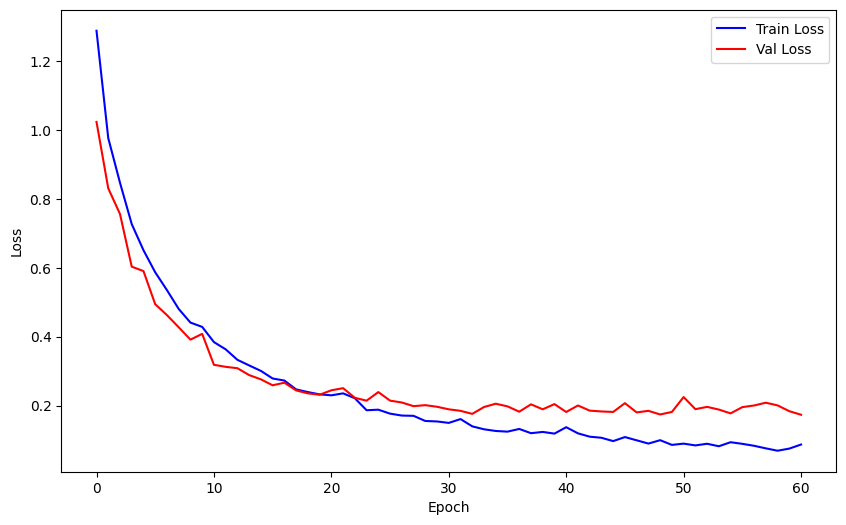

In [26]:
train_loss_df = pd.read_csv("/content/train_loss.csv")
val_loss_df = pd.read_csv("/content/val_loss.csv")

plt.figure(figsize=(10, 6))
plt.plot(train_loss_df['Step'], train_loss_df['Value'], label='Train Loss', color='blue')
plt.plot(val_loss_df['Step'], val_loss_df['Value'], label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
y_logits = model.predict(dataset_test)
y_prob = tf.nn.softmax(y_logits, axis=1)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(dataset_test.map(lambda s,lab: lab)), axis=0)

16/16 [==============================] - 4s 199ms/step


In [23]:
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovo')
print(f"F1: {f1} | Precision: {precision} | Recall: {recall} | AUC: {auc}")

F1: 0.9594888853908966 | Precision: 0.9605069627743766 | Recall: 0.9587756206603573 | AUC: 0.9959998246213567


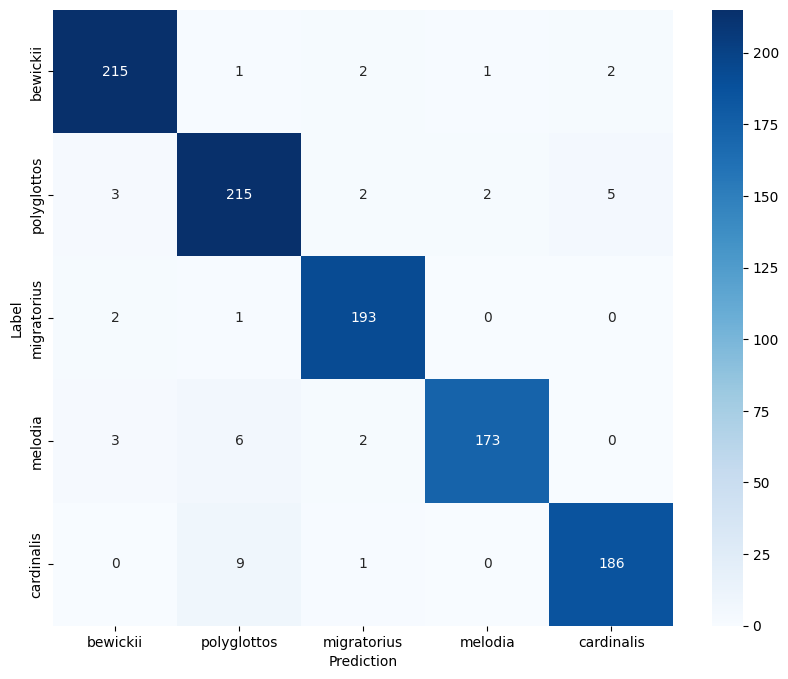

In [24]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()